# <span style="color:lightblue">Clusterization - Primer</span>
When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

## <span style="color: #9999ff">Load Wikipedia dataset</span>

We will be using the dataset of abridged Wikipedia pages. Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [110]:
wiki = pd.read_csv('./datasets/people_wiki.csv')
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former australian rules footballer who played with the kangaroos and carlton in the australian football league aflfrom western australia morrell played his early senior football for west perth his 44game senior career for the falcons spanned 19982000 and he was the clubs leading goalkicker in 2000 at the age of 21 morrell was recruited to the australian football league by the kangaroos football club with its third round selection in the 2001 afl rookie draft as a forward he twice kicked five goals during his time with the kangaroos the first was in a losing cause against sydney in 2002 and the other the following season in a drawn game against brisbaneafter the 2003 season morrell was traded along with david teague to the carlton football club in exchange for corey mckernan he played 32 games for the blues before being delisted at the end of 2005 he continued to play victorian football league vfl football with the northern bullants carltons vflaffiliate in 2006 and acted as playing assistant coach in 2007 in 2008 he shifted to the box hill hawks before retiring from playing at the end of the season from 2009 until 2013 morrell was the senior coach of the strathmore football club in the essendon district football league leading the club to the 2011 premier division premiership since 2014 he has coached the west coburg football club also in the edflhe currently teaches physical education at parade college in melbourne
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from university of chicago in 1973 after studying psychiatry pharmacology and ophthalmology he is a full professor and vicechair of the department of psychiatry at ohsu oregon health science university and holds an md and phd prior to moving to oregon in 1981 lewy was at the national institute of mental health nimh in bethesda maryland working with senior colleague thomas wehr in oregon he has worked closely with robert l sack as of december 2005 he had 94 publications available on pubmed he describes his research as follows my laboratory studies chronobiologic sleep and mood disorders these disorders include winter depression jet lag maladaptation to shift work and certain types of sleep disturbances relying on a very precise assay for plasma melatonin a hormone that has a clearly defined 24hour pattern of secretion biological rhythm disorders can be assessed and their treatment can be monitored current research is focused on developing bright light exposure and melatonin administration as treatment modalities for these disorders treatment must be precisely scheduled morning light exposure and evening melatonin administration cause circadian phaseadvance shifts evening light exposure and morning melatonin administration cause circadian phasedelay shifts totally blind individuals have 25hour circadian rhythms drifting an hour later each day unless they take a melatonin capsule at a certain time every day
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player who has been active in canadas blues scene since 1982 hailing from vancouver he crossed tens of thousands of miles playing club dates and festivals in canada the northwestern united states and germanyover the years he has issued seven cds in 1995 his home is where the harp is won the muddy award for the best nw blues release from the cascade blues association in portland oregon as well that year it was nominated for a canadian juno for the best bluesgospel recording teamed up with graham guest on piano his cd naturally was voted 1 canadian blues album of 2010 by the blind lemon surveybrown tours extensively with his guitarist j arthur edmonds performing their electric mid1950s chicago blues either as a duo or with the full band while he is home he juggles a few combos working many venues big and sm

## <span style="color: #9999ff">Ex. 1: Extract word count vectors</span>


As we have seen in Assignment 4, we can extract word count vectors using `CountVectorizer` function.
- make sure you include words of unit length by using the parameter: `token_pattern=r"(?u)\b\w+\b"`
- do not use any stopwords
- take 10000 most frequent words in the corpus
- explicitly take all the words independent of in how many documents they occur
- obtain the matrix of word counts

In [111]:
vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
WCmatrix = vectorizer.fit_transform(wiki.text)

In [112]:
print(f"Ilość słów branych pod uwagę w modelu: {len(vectorizer.get_feature_names_out())}")

Ilość słów branych pod uwagę w modelu: 548465


In [113]:
words = vectorizer.get_feature_names_out()
word_counts = WCmatrix.sum(axis=0).A1
word_freq = pd.DataFrame({'word': words, 'count': word_counts})
word_freq.sort_values(by='count', ascending=False, inplace=True)
ten_thous_most = word_freq.head(10000)
ten_thous_most.reset_index(drop=True, inplace=True)
ten_thous_most.head(5)

,word,count
0,the,1156479
1,in,668317
2,and,641587
3,of,631290
4,a,406426


In [114]:
vectorizer_limited = CountVectorizer(vocabulary=ten_thous_most.word.tolist())
WCmatrix_limited = vectorizer_limited.fit_transform(wiki.text)
X = WCmatrix_limited
y = vectorizer_limited.transform((wiki[wiki.name == "Barack Obama"]).text)
print(f"Ilość słów branych pod uwagę w modelu: {len(vectorizer_limited.get_feature_names_out())}")

Ilość słów branych pod uwagę w modelu: 10000


> 📝 <span style="color:lightblue">Komentarz:</span> Zaczynamy od podstawowej metody, czyli bag of words. Na początku zliczamy wszystkie słowa i widzimy, że nasz model będzie złożony bo wymiar wejściowy będzie wynosił 548465, to naprawdę dużo. Robimy więc trick, że bierzemy tylko najczęściej pojawiające się słowa, ale ma to swoje wady, istotnie, tracimy istotne informację z dołu, gdyż słowa żadko się pojawiające, nie będą rozpatrywane, jak zobaczymy później mają one kluczowe znaczenie.

## <span style="color: #9999ff">Ex. 2: Find nearest neighbors</span>


**a)** Start by finding the nearest neighbors of the Barack Obama page using the above word count matrix to represent the articles and **Euclidean** distance to measure distance.
Save the distances in `wiki['BO-eucl']` and look at the top 10 nearest neighbors.

In [115]:
dist = pairwise_distances(X,y)
wiki_dist = wiki.copy()
wiki_dist['BO-eucl'] = dist
wiki_dist.sort_values(by='BO-eucl', ascending=True, inplace=True)

In [116]:
wiki_dist.head(10)

,URI,name,text,BO-eucl
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born august 4 1961 is the 44th and current president of the united states and the first african american to hold the office born in honolulu hawaii obama is a graduate of columbia university and harvard law school where he served as president of the harvard law review he was a community organizer in chicago before earning his law degree he worked as a civil rights attorney and taught constitutional law at the university of chicago law school from 1992 to 2004 he served three terms representing the 13th district in the illinois senate from 1997 to 2004 running unsuccessfully for the united states house of representatives in 2000in 2004 obama received national attention during his campaign to represent illinois in the united states senate with his victory in the march democratic party primary his keynote address at the democratic national convention in july and his election to the senate in november he began his presidential campaign in 2007 and after a close primary campaign against hillary rodham clinton in 2008 he won sufficient delegates in the democratic party primaries to receive the presidential nomination he then defeated republican nominee john mccain in the general election and was inaugurated as president on january 20 2009 nine months after his election obama was named the 2009 nobel peace prize laureateduring his first two years in office obama signed into law economic stimulus legislation in response to the great recession in the form of the american recovery and reinvestment act of 2009 and the tax relief unemployment insurance reauthorization and job creation act of 2010 other major domestic initiatives in his first term included the patient protection and affordable care act often referred to as obamacare the doddfrank wall street reform and consumer protection act and the dont ask dont tell repeal act of 2010 in foreign policy obama ended us military involvement in the iraq war increased us troop levels in afghanistan signed the new start arms control treaty with russia ordered us military involvement in libya and ordered the military operation that resulted in the death of osama bin laden in january 2011 the republicans regained control of the house of representatives as the democratic party lost a total of 63 seats and after a lengthy debate over federal spending and whether or not to raise the nations debt limit obama signed the budget control act of 2011 and the american taxpayer relief act of 2012obama was reelected president in november 2012 defeating republican nominee mitt romney and was sworn in for a second term on january 20 2013 during his second term obama has promoted domestic policies related to gun control in response to the sandy hook elementary school shooting and has called for full equality for lgbt americans while his administration has filed briefs which urged the supreme court to strike down the defense of marriage act of 1996 and californias proposition 8 as unconstitutional in foreign policy obama ordered us military involvement in iraq in response to gains made by the islamic state in iraq after the 2011 withdrawal from iraq continued the process of ending us combat operations in afghanistan and has sought to normalize us relations with cuba,0.000000
24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn born november 20 1942 is the 47th and current vice president of the united states jointly elected with president barack obama he is a member of the democratic party and was a united states senator from delaware from january 3 1973 until his resignation on january 15 2009 following his election to the vice presidency in 2012 biden was elected to a second term alongside obamabiden was born in scranton pennsylvania and lived there for ten years before moving to delaware he became an attorney in 1969 and was elected to the n

**b)** Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

In [117]:
barrack = ("barrack",y)
bush = ("bush",vectorizer_limited.transform(wiki[wiki.name == 'George W. Bush'].text).toarray())
biden = ("biden",vectorizer_limited.transform(wiki[wiki.name == 'Joe Biden'].text).toarray())
for x,y in itertools.combinations([barrack,bush,biden], 2):
    print(f"Distance {x[0]}-{y[0]}: {pairwise_distances(x[1],y[1])}")

Distance barrack-bush: [[33.57082066]]
Distance barrack-biden: [[31.28897569]]
Distance bush-biden: [[30.85449724]]


All of the 10 people from **a)** are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians, e.g.,

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

**c)** Let's find out why Francisco Barrio was considered a close neighbor of Obama.
To do this, look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

In [118]:
def top_words(name):
    df = pd.DataFrame({
        'words':vectorizer_limited.get_feature_names_out(),
        'count': vectorizer_limited.transform(wiki[wiki.name == name].text).toarray()[0]
    })
    df = df[df['count']>0]
    return df.sort_values(by='count',ascending=False)

In [119]:
obama_words = top_words('Barack Obama')
obama_words

,words,count
0,the,40
1,in,30
2,and,21
3,of,18
6,to,14
...,...,...
846,ii,1
855,relations,1
860,defeated,1
881,nine,1


In [120]:
barrio_words = top_words('Francisco Barrio')
barrio_words

,words,count
0,the,36
3,of,24
2,and,18
1,in,17
5,he,10
...,...,...
457,politician,1
476,women,1
489,federal,1
502,due,1


> 📝 <span style="color:lightblue">Komentarz:</span> No właśnie widzimy, że dominujące słowa to są tzw stopwordy angielskie i nie za bardzo dają one jakiekolwiek znaczenie do naszych wektorów a i tak brane są pod uwagę. Przez co dostajemy zbliżone wyniki przeszukiwań, ale odbiegają one od siebie jeśli chodzi o szczegóły(mma na myśli, że rzeczywiście dostajemy polityków, ale często różnych partii, narodowości itd.) Widzimy, że słowa najbardziej znaczące to m.in. 'governor', 'state'. 

**d)** Extract the list of most frequent **common** words that appear in both Obama's and Barrio's documents and display the five words that appear most often in Barrio's article.

Use a dataframe operation known as **join**. The **join** operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the index column of words). See [the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) for more details.

In [121]:
common_words = obama_words.join(barrio_words, rsuffix='_Barrio', lsuffix='_Obama', how='inner')
common_words.sort_values(by='count_Barrio', ascending=False,inplace=True)
common_words.head(15)

,words_Obama,count_Obama,words_Barrio,count_Barrio
0,the,40,the,36
3,of,18,of,24
2,and,21,and,18
1,in,30,in,17
5,he,7,he,10
6,to,14,to,9
10,his,11,his,5
9,as,6,as,5
15,from,3,from,4
70,state,1,state,4


Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page. 

In [122]:
bush_words = top_words('George W. Bush')
obama_words.join(bush_words, rsuffix='_Bush', lsuffix='_Obama', how='inner').sort_values(by='count_Obama', ascending=False).head(10)

,words_Obama,count_Obama,words_Bush,count_Bush
0,the,40,the,39
1,in,30,in,22
2,and,21,and,14
3,of,18,of,14
6,to,14,to,11
10,his,11,his,6
905,act,8,act,3
5,he,7,he,8
129,law,6,law,1
9,as,6,as,6


**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

**e)** Among the words that appear in both Barack Obama and Francisco Barrio, take the 15 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [123]:
common_words_obama = obama_words.join(barrio_words, rsuffix='_Barrio', lsuffix='_Obama', how='inner')
common_words.sort_values(by='count_Obama', ascending=False,inplace=True)
common_words.head(15)

,words_Obama,count_Obama,words_Barrio,count_Barrio
0,the,40,the,36
1,in,30,in,17
2,and,21,and,18
3,of,18,of,24
6,to,14,to,9
10,his,11,his,5
5,he,7,he,10
9,as,6,as,5
7,was,5,was,4
1205,control,4,control,2


In [142]:
word_to_ind={v: i for i, v in enumerate(vectorizer_limited.get_feature_names_out())}
most_common_words = common_words["words_Obama"][:15].tolist()
for i in word_to_ind.copy().keys():
    if i not in most_common_words:
        word_to_ind.pop(i)
word_index = pd.DataFrame({
    'words':word_to_ind.keys(),
    'index':word_to_ind.values()
})
    
contains_all = []
for article in X.toarray():
    flag = True
    for index in word_index['index']:
        if article[index] == 0:
            flag = False
    if flag:
        contains_all.append(1)
    else:
        contains_all.append(np.nan)
        
articles = pd.DataFrame({
    "name":wiki.name,
    "text":wiki.text,
    "contains": contains_all
})
articles.dropna(inplace=True) 
articles.sort_values(by='name',axis='index',ascending=True, inplace=True)
print(sum(articles['contains']))

20.0


In [125]:
articles.name

29505            Arturo Vallarino
35817                Barack Obama
4874                Bernard Kenny
36452                Bill Clinton
1413                Chris Redfern
1177                Donald Fowler
53102                 Ewart Brown
13229            Francisco Barrio
28447              George W. Bush
11316    Gy%C3%B6rgy Sur%C3%A1nyi
56172                   Hu Jintao
24417               Jesse Ventura
35541                Jimmy Carter
24478                   Joe Biden
38081              John Garamendi
12371             Morley Winograd
6617                   Paul Sarlo
52229         Robert Lewis Morgan
50868               Russell Trood
48253     Saber Hossain Chowdhury
Name: name, dtype: object

> 📝 <span style="color:lightblue">Komentarz:</span> Skomentuje jeszcze może tylko rozbieżność liczb artykułów, istotnie, ale akurat tak trafiliśmy, że nasze sortowanie nie jest jednoznacze, bo jest kilkadziesiąt wartości, których suma wynosi 4, i dostajemy je losowo, więc dlatego może się to trochę różnić, ale w ogólności, artykuły jakie dostajemy są prawie takie same, może z jedną różnicą. Widzimy, że tylko 20 artykułów, ma wszystkie 15 najczęściej pojawiających się słów z artykułu obamy(ale wspólne słowa również dla artykułu Barria), jest to mała liczba. Zobaczmy na to, że słowa, które sprawdzamy są wspólnymi słowami występującymi u Obamy i Barria w artykółach, widzimy, że mało jest artykułów, które miały by te same słowa co te dwa artykuły. Ja to interpretuje w ten sposób, że już te dwa artykuły razem wziętę dość dobrze zawężają nam zbiór podobnych artykułów do tych dwóch.

## <span style="color: #9999ff">Ex. 3: TF-IDF to the rescue

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons.

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common.

**a)** Repeat the search for the 10 nearest neighbors of Barack Obama with Euclidean distance of TF-IDF. This time do not limit to only 10000 most frequent words, but take all of them.

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipeline = Pipeline([
    ('vectorizer', CountVectorizer(token_pattern=r"(?u)\b\w+\b")),
    ('tfidf', TfidfTransformer(smooth_idf=False,norm=None)) 
])

TFIDFmatrix = pipeline.fit_transform(wiki.text)
obama_tf_idf = pipeline.transform(wiki[wiki.name=='Barack Obama'].text)

In [127]:
# now recompute the distances as before but for TF-IDF
dist = pairwise_distances(TFIDFmatrix,obama_tf_idf)
wiki_dist = wiki.copy()
wiki_dist['BO-eucl-TF-IDF'] = dist
wiki_dist.sort_values(by='BO-eucl-TF-IDF', ascending=True, inplace=True)
wiki_dist.head(10)

,URI,name,text,BO-eucl-TF-IDF
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born august 4 1961 is the 44th and current president of the united states and the first african american to hold the office born in honolulu hawaii obama is a graduate of columbia university and harvard law school where he served as president of the harvard law review he was a community organizer in chicago before earning his law degree he worked as a civil rights attorney and taught constitutional law at the university of chicago law school from 1992 to 2004 he served three terms representing the 13th district in the illinois senate from 1997 to 2004 running unsuccessfully for the united states house of representatives in 2000in 2004 obama received national attention during his campaign to represent illinois in the united states senate with his victory in the march democratic party primary his keynote address at the democratic national convention in july and his election to the senate in november he began his presidential campaign in 2007 and after a close primary campaign against hillary rodham clinton in 2008 he won sufficient delegates in the democratic party primaries to receive the presidential nomination he then defeated republican nominee john mccain in the general election and was inaugurated as president on january 20 2009 nine months after his election obama was named the 2009 nobel peace prize laureateduring his first two years in office obama signed into law economic stimulus legislation in response to the great recession in the form of the american recovery and reinvestment act of 2009 and the tax relief unemployment insurance reauthorization and job creation act of 2010 other major domestic initiatives in his first term included the patient protection and affordable care act often referred to as obamacare the doddfrank wall street reform and consumer protection act and the dont ask dont tell repeal act of 2010 in foreign policy obama ended us military involvement in the iraq war increased us troop levels in afghanistan signed the new start arms control treaty with russia ordered us military involvement in libya and ordered the military operation that resulted in the death of osama bin laden in january 2011 the republicans regained control of the house of representatives as the democratic party lost a total of 63 seats and after a lengthy debate over federal spending and whether or not to raise the nations debt limit obama signed the budget control act of 2011 and the american taxpayer relief act of 2012obama was reelected president in november 2012 defeating republican nominee mitt romney and was sworn in for a second term on january 20 2013 during his second term obama has promoted domestic policies related to gun control in response to the sandy hook elementary school shooting and has called for full equality for lgbt americans while his administration has filed briefs which urged the supreme court to strike down the defense of marriage act of 1996 and californias proposition 8 as unconstitutional in foreign policy obama ordered us military involvement in iraq in response to gains made by the islamic state in iraq after the 2011 withdrawal from iraq continued the process of ending us combat operations in afghanistan and has sought to normalize us relations with cuba,0.000000
38376,<http://dbpedia.org/resource/Samantha_Power>,Samantha Power,samantha power born september 21 1970 is an irishborn american academic author and diplomat who currently serves as the united states ambassador to the united nationspower began her career by covering the yugoslav wars as a journalist from 1998 to 2002 power served as the founding executive director of the carr center for human rights policy at harvard universitys kennedy school of government where she later served as the anna lindh professor of practice of global leadership and public policy she was a senior adviser to senator barack obama until m

Let's determine whether this list makes sense.
* With a notable exception of Nathan Cullen, the other 8 are all American politicians who are contemporaries of Barack Obama.
* Phil Schiliro, Jesse Lee, Samantha Power, Eric Stern, Eric Holder worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Schilirio's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document.

**b)** Sort the words in Obama's article by their TF-IDF weights; do the same for Schiliro's article as well.
Using the **join** operation we learned earlier, compute the common words shared by Obama's and Schiliro's articles.
Sort the common words by their TF-IDF weights in Obama's document.

In [128]:
def top_words_tf_idf(name):
    text = wiki[wiki.name == name].text
    text_tfidf = pipeline.transform(text).toarray()[0]
    words = vectorizer.get_feature_names_out()
    df = pd.DataFrame({
        'tf-idf': text_tfidf,
    }, index=words)
    df = df[df['tf-idf']>0]
    return df.sort_values(by='tf-idf',ascending=False)

In [129]:
obama_tf_idf = top_words_tf_idf('Barack Obama')
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
common_words_tfidf = obama_tf_idf.join(other=schiliro_tf_idf, rsuffix='_Schiliro', lsuffix='_Obama', how='inner')
common_words_tfidf.head(15)

,tf-idf_Obama,tf-idf_Schiliro
obama,52.295653,11.621256
the,40.004063,10.001016
in,30.028962,5.004827
and,21.015648,6.004471
law,20.722936,10.361468
of,18.074811,9.037406
democratic,16.410689,8.205344
to,14.657229,7.328615
his,13.888726,1.262611
senate,13.164288,4.388096


**c)** Among the words that appear in both Barack Obama and Phil Schiliro, take the 15 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 15 words? Which are they?

In [130]:
# It might be helpful to use:
words_index = {word: index for index, word in enumerate(vectorizer.get_feature_names_out())}
words_obama = common_words_tfidf.index.values[:15]
for word in words_index.copy().keys():
    if word not in words_obama:
        words_index.pop(word)
contains_all = []

for row_index in range(TFIDFmatrix.shape[0]):
    row = TFIDFmatrix.getrow(row_index)
    flag = True
    for index in words_index.values():
        if row[0,index] == 0:
            flag = False
    if flag:
        contains_all.append(1)
    else:  
        contains_all.append(np.nan)
articles_stat = pd.DataFrame({
    'name':wiki.name,
    'contains_obama':contains_all
})   
# Your code goes here
articles_stat.sum()

name              Digby MorrellAlfred J. LewyHarpdog BrownFranz RottensteinerG-EnkaSam HendersonAaron LaCrateTrevor FergusonGrant NelsonCathy CaruthSophie CrumbJenn AshworthJonathan HoeflerAnthony Gueterbock, 18th Baron BerkeleyDavid ChernushenkoJoerg SteineckAndrew PinsentPaddy Dunne (Gaelic footballer)Alexandros MouzasJohn Angus CampbellChris BatstoneCeiron ThomasAdel SellimiFaith SolowayTom JenningsVic StasiukAnthony CaruanaIan Mitchell (author)Leon HapgoodEmily OsmentDom FloraTed Hill (mathematician)Mindaugas MurzaBob ReeceDouglas DaviesFreimut B%C3%B6rngenTh%C3%BCring Br%C3%A4mAharon SolomonsSteven WeilGary EminethTimothy GruczaBob Adams (American football)Sylvie RoyRob SheffieldMichel CheJaafar AksikasWill TuttleVanessa AmentMarc LoganCorey WoolfolkProfessor Lyrical (rapper)Michelle YeRobert N. ChatignyVincent Fang (lyricist)Misa Telefoni RetzlaffMary GoldringSusan Westerberg PragerYohannes YualChristopher SorrentinoAlexis BhagatDavid Vernon WilliamsGuillermo RouxWilliam J. ElyAl

In [131]:
articles_stat[articles_stat['contains_obama']==1]

,name,contains_obama
7914,Phil Schiliro,1.0
24478,Joe Biden,1.0
35817,Barack Obama,1.0


Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

> 📝 <span style="color:lightblue">Komentarz:</span> Pamiętamy, że TF-IDF, kładzie nacisk, na słowa żadko występujące w dokumentach, więc ćwiczymy nasz vectorizer na wszystkich słowach. Widzimy, że wyniki są o wiele bardziej sensowne, artykuły tearz zbliżone są nie tylko tym, że mamy polityków, ale także ludzi rzeczwyiście zbliżonych do siebie jeśli chodzi o szczegóły. Widzimy, że TF-IDF, przypiusuje jakby 'wage' do każdego z licznika słów w bag of word. Te żadko wystepujące dostają większą wagę(zgodnie ze wzorem z wykładu), a te częste jak np 'the' dostają wagę o wiele niższą. Widzimy, też, że od razu zmiejszyła się liczba artykółów, które mają dokładnie taką samą liczbę najczęstszych słow w artykule obamy(analogicznie jak wyżej), ale tym razem artykóły te są bardzo do siebie podobne(wygooglowałem sobie i rzeczywiście dostaliśmy dobrą rekomendację). Istotnie również odległości od artykułów są relatywnie wyższe niz jak braliśmy 10000 słow, ale jest to oczywiste, bo podwyższając wymiar odległość między punktami zazwyczaj nam wzrośnie(klątwa wielowymiarowości)

## <span style="color: #9999ff">Ex. 4: Choosing metrics

**a)** Compute the Euclidean distance between TF-IDF features of Obama and Biden.

In [132]:
biden_tf_idf = pipeline.transform(wiki[wiki.name=='Joe Biden'].text)
obama_tf_idf = pipeline.transform(wiki[wiki.name=='Barack Obama'].text)
dist = euclidean_distances(biden_tf_idf,obama_tf_idf)
dist

array([[148.77845413]])

The distance is larger than the distances we found for the 10 nearest neighbors, which we repeat here for readability:

In [133]:
wiki_dist.head(10)[['name','BO-eucl-TF-IDF']]

,name,BO-eucl-TF-IDF
35817,Barack Obama,0.000000
38376,Samantha Power,139.364493
46811,Jeff Sessions,139.757740
7914,Phil Schiliro,139.812175
38714,Eric Stern (politician),140.450064
6507,Bob Menendez,141.661111
44681,Jesse Lee (politician),142.342440
6796,Eric Holder,142.490179
38495,Barney Frank,142.581337
56008,Nathan Cullen,142.751073


But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones.

**b)** Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page. To compute text length use the same splitting rules you used in `vectorizer`.

In [134]:
tokenizer = lambda x: x.split()
def compute_length(row):
    return len(tokenizer(row['text']))

nbrs = NearestNeighbors(n_neighbors=100, algorithm='brute').fit(TFIDFmatrix)
dist, indices = nbrs.kneighbors(obama_tf_idf)
articles_obama = wiki.loc[indices[0]]
articles_obama['length'] = [compute_length(row) for _,row in articles_obama.iterrows()]
articles_obama['dist'] = dist[0]

wiki['length'] = [compute_length(row) for _,row in wiki.iterrows()]
articles_obama.head(16)

,URI,name,text,length,dist
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born august 4 1961 is the 44th and current president of the united states and the first african american to hold the office born in honolulu hawaii obama is a graduate of columbia university and harvard law school where he served as president of the harvard law review he was a community organizer in chicago before earning his law degree he worked as a civil rights attorney and taught constitutional law at the university of chicago law school from 1992 to 2004 he served three terms representing the 13th district in the illinois senate from 1997 to 2004 running unsuccessfully for the united states house of representatives in 2000in 2004 obama received national attention during his campaign to represent illinois in the united states senate with his victory in the march democratic party primary his keynote address at the democratic national convention in july and his election to the senate in november he began his presidential campaign in 2007 and after a close primary campaign against hillary rodham clinton in 2008 he won sufficient delegates in the democratic party primaries to receive the presidential nomination he then defeated republican nominee john mccain in the general election and was inaugurated as president on january 20 2009 nine months after his election obama was named the 2009 nobel peace prize laureateduring his first two years in office obama signed into law economic stimulus legislation in response to the great recession in the form of the american recovery and reinvestment act of 2009 and the tax relief unemployment insurance reauthorization and job creation act of 2010 other major domestic initiatives in his first term included the patient protection and affordable care act often referred to as obamacare the doddfrank wall street reform and consumer protection act and the dont ask dont tell repeal act of 2010 in foreign policy obama ended us military involvement in the iraq war increased us troop levels in afghanistan signed the new start arms control treaty with russia ordered us military involvement in libya and ordered the military operation that resulted in the death of osama bin laden in january 2011 the republicans regained control of the house of representatives as the democratic party lost a total of 63 seats and after a lengthy debate over federal spending and whether or not to raise the nations debt limit obama signed the budget control act of 2011 and the american taxpayer relief act of 2012obama was reelected president in november 2012 defeating republican nominee mitt romney and was sworn in for a second term on january 20 2013 during his second term obama has promoted domestic policies related to gun control in response to the sandy hook elementary school shooting and has called for full equality for lgbt americans while his administration has filed briefs which urged the supreme court to strike down the defense of marriage act of 1996 and californias proposition 8 as unconstitutional in foreign policy obama ordered us military involvement in iraq in response to gains made by the islamic state in iraq after the 2011 withdrawal from iraq continued the process of ending us combat operations in afghanistan and has sought to normalize us relations with cuba,540,0.000000
38376,<http://dbpedia.org/resource/Samantha_Power>,Samantha Power,samantha power born september 21 1970 is an irishborn american academic author and diplomat who currently serves as the united states ambassador to the united nationspower began her career by covering the yugoslav wars as a journalist from 1998 to 2002 power served as the founding executive director of the carr center for human rights policy at harvard universitys kennedy school of government where she later served as the anna lindh professor of practice of global leadership and public policy she was a senior adviser to senator barack obama until 

**c)** To see how these document lengths compare to the lengths of other documents in the corpus, make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

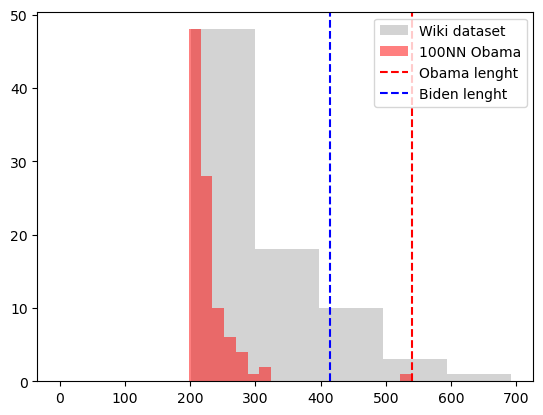

In [135]:
plt.hist(wiki.sample(80).length.values,bins=5,alpha=1, label='Wiki dataset', color='lightgrey') 
plt.hist(articles_obama.length.values,range=(0,max(articles_obama.length)), bins=30, alpha=0.5, label='100NN Obama', color='red') 
plt.axvline(x=wiki[wiki.name=='Barack Obama'].length.values,linestyle='--', label='Obama lenght', color='red')
plt.axvline(x=wiki[wiki.name=='Joe Biden'].length.values,linestyle='--', label='Biden lenght', color='blue')
plt.legend()
plt.show()

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains _excerpts_ of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

**d)** Train a new nearest neighbor model, this time with cosine distances.  Then repeat the search for Obama's 100 nearest neighbors and make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

In [136]:
dist = pairwise_distances(TFIDFmatrix,obama_tf_idf, metric='cosine')
wiki_dist = wiki.copy()
try:
    wiki_dist.pop('length')
except KeyError:pass
wiki_dist['BO-cos-TF-IDF'] = dist
wiki_dist['length'] = [compute_length(row) for _,row in wiki_dist.iterrows()]
wiki_dist.sort_values(by='BO-cos-TF-IDF', ascending=True, inplace=True)
wiki_dist.head(15)

URI  \
35817             <http://dbpedia.org/resource/Barack_Obama>   
24478                <http://dbpedia.org/resource/Joe_Biden>   
57108   <http://dbpedia.org/resource/Hillary_Rodham_Clinton>   
38376           <http://dbpedia.org/resource/Samantha_Power>   
38714  <http://dbpedia.org/resource/Eric_Stern_(politician)>   
28447           <http://dbpedia.org/resource/George_W._Bush>   
39357              <http://dbpedia.org/resource/John_McCain>   
48693              <http://dbpedia.org/resource/Artur_Davis>   
18827             <http://dbpedia.org/resource/Henry_Waxman>   
37199  <http://dbpedia.org/resource/Barry_Sullivan_(lawyer)>   
46811            <http://dbpedia.org/resource/Jeff_Sessions>   
36452             <http://dbpedia.org/resource/Bill_Clinton>   
6796               <http://dbpedia.org/resource/Eric_Holder>   
24848          <http://dbpedia.org/resource/John_C._Eastman>   
36425     <http://dbpedia.org/resource/Edward_B._Montgomery>   

                          name  \
35817             Barack Obama   
24478                Joe Biden   
57108   Hillary Rodham Clinton   
38376           Samantha Power   
38714  Eric Stern (politician)   
28447           George W. Bush   
39357              John McCain   
48693              Artur Davis   
18827             Henry Waxman   
37199  Barry Sullivan (lawyer)   
46811            Jeff Sessions   
36452             Bill Clinton   
6796               Eric Holder   
24848          John C. Eastman   
36425     Edward B. Montgomery   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

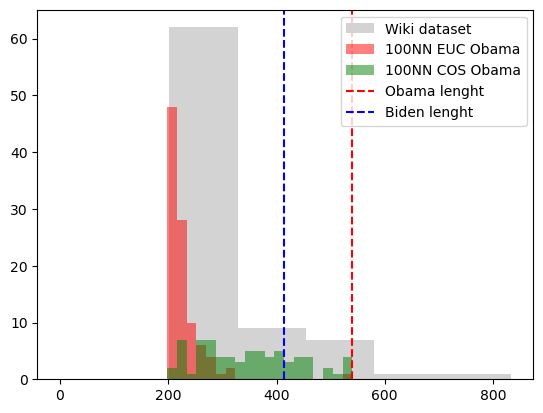

In [137]:
plt.hist(wiki.sample(80).length.values,bins=5,alpha=1, label='Wiki dataset', color='lightgrey')  # Histogram for data
plt.hist(articles_obama.length.values,range=(0,max(articles_obama.length)), bins=30, alpha=0.5, label='100NN EUC Obama', color='red')
plt.hist(wiki_dist.head(100).length.values,range=(0,max(articles_obama.length)), bins=30, alpha=0.5, label='100NN COS Obama', color='green')
plt.axvline(x=wiki[wiki.name=='Barack Obama'].length.values,linestyle='--', label='Obama lenght', color='red')
plt.axvline(x=wiki[wiki.name=='Joe Biden'].length.values,linestyle='--', label='Biden lenght', color='blue')
plt.legend()
plt.show()

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

> 📝 <span style="color:lightblue">Komentarz:</span> Widzimy, że metryka euklidesowa, woli brać krótsze artykuły. (Zastanawia mnie czy to zostałoby naprawione jeżeli użylibyśmy normalizacji, choć wydaję mi się, że nie usunelibyśmy całkowicie tego problemu to jednak troche byśmy go złagodzili, oczywiście wtedy zrównamy(patrząc na podobieństwo) krótsze i dłuższe artykuły, ale chyba wyniki byłyby bardziej sensowne i rozrzucone?). Istotnie widzimy, że metryka cos, radzi sobie lepiej niż euklidesowa, ona działa trochę inaczej, bo zamiast bazować głównie na odległości między wektorami to skupia się na ich kierunku. To tłumaczy dlaczego jest lepiej, jeśli chodzi o długośc artykułów oraz co dostajemy jako podobne artykuły. No tylko właśnie, kładzenie nacisku na kierunku ma swoje konsekwencje...

## <span style="color: #9999ff">Ex. 5: Problem with cosine distances: tweets vs. long articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

**a)** Transform the tweet into TF-IDF features, using the fit to the Wikipedia dataset. (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.) How similar is this tweet to Barack Obama's Wikipedia article? 

In [138]:
df = pd.DataFrame({'text': ['democratic governments control law in response to popular act']})
tweet_tfidf = pd.DataFrame({
    'count':pipeline.transform(df.text).toarray()[0]
},index=vectorizer.get_feature_names_out())
tweet_tfidf = tweet_tfidf[tweet_tfidf['count']>0]
tweet = 'democratic governments control law in response to popular act'
tweet_tfidf
# Your code goes here

,count
act,4.459778
control,4.721765
democratic,4.102672
governments,5.167571
in,1.000965
law,3.453823
popular,3.764479
response,5.261462
to,1.046945


Let's compare this tweet's TF-IDF vectors  to Barack Obama's Wikipedia entry.

In [139]:
obama_tf_idf = top_words_tf_idf('Barack Obama')
obama_tf_idf

,tf-idf
obama,52.295653
the,40.004063
act,35.678223
in,30.028962
iraq,21.747379
...,...
is,2.055233
new,1.887235
which,1.767431
that,1.661407


**b)** Now, compute the cosine distance between the Barack Obama article and this tweet:

Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia nearest neighbors:

In [140]:
distance_barack_tweet = cosine_distances(pipeline.transform(wiki[wiki.name=='Barack Obama'].text),pipeline.transform(df.text))[0][0]
print(distance_barack_tweet)
# Your code goes here

0.6986645349790674


In [141]:
wiki_dist.loc[len(wiki_dist)] = ["<http://nic.org>", "tweet", tweet, distance_barack_tweet,len(tweet)]
wiki_dist.sort_values(by='BO-cos-TF-IDF', ascending=True, inplace=True)
wiki_dist[0:23]

URI  \
35817                 <http://dbpedia.org/resource/Barack_Obama>   
24478                    <http://dbpedia.org/resource/Joe_Biden>   
57108       <http://dbpedia.org/resource/Hillary_Rodham_Clinton>   
38376               <http://dbpedia.org/resource/Samantha_Power>   
38714      <http://dbpedia.org/resource/Eric_Stern_(politician)>   
28447               <http://dbpedia.org/resource/George_W._Bush>   
39357                  <http://dbpedia.org/resource/John_McCain>   
48693                  <http://dbpedia.org/resource/Artur_Davis>   
18827                 <http://dbpedia.org/resource/Henry_Waxman>   
37199      <http://dbpedia.org/resource/Barry_Sullivan_(lawyer)>   
46811                <http://dbpedia.org/resource/Jeff_Sessions>   
36452                 <http://dbpedia.org/resource/Bill_Clinton>   
6796                   <http://dbpedia.org/resource/Eric_Holder>   
24848              <http://dbpedia.org/resource/John_C._Eastman>   
36425         <http://dbpedia.org/resource/Edward_B._Montgomery>   
14754                  <http://dbpedia.org/resource/Mitt_Romney>   
35357             <http://dbpedia.org/resource/Lawrence_Summers>   
47303                   <http://dbpedia.org/resource/John_Kerry>   
34344  <http://dbpedia.org/resource/Mary_Dawson_(civil_servant)>   
55181                     <http://dbpedia.org/resource/Ron_Paul>   
4565           <http://dbpedia.org/resource/Robinson_O._Everett>   
46140                 <http://dbpedia.org/resource/Robert_Gibbs>   
59071                                           <http://nic.org>   

                              name  \
35817                 Barack Obama   
24478                    Joe Biden   
57108       Hillary Rodham Clinton   
38376               Samantha Power   
38714      Eric Stern (politician)   
28447               George W. Bush   
39357                  John McCain   
48693                  Artur Davis   
18827                 Henry Waxman   
37199      Barry Sullivan (lawyer)   
46811                Jeff Sessions   
36452                 Bill Clinton   
6796                   Eric Holder   
24848              John C. Eastman   
36425         Edward B. Montgomery   
14754                  Mitt Romney   
35357             Lawrence Summers   
47303                   John Kerry   
34344  Mary Dawson (civil servant)   
55181                     Ron Paul   
4565           Robinson O. Everett   
46140                 Robert Gibbs   
59071                        tweet   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

With cosine distances, the tweet is "nearer" to Barack Obama than most people! If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet?
In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from _The Atlantic_, you wouldn't recommend him/her a tweet.

> 📝 <span style="color:lightblue">Komentarz:</span> Konsekwencje o których wspominałem wyżej są wymieniane tutaj, widzimy, że ponieważ nasz tweet zawiera dużo kluczowych słów, zapewne na w hiperukładzie współrzednych ma niewielki kąt nachylenia do wektora artykułu barracka obamy. Co istotne, dostajemy bardzo fajnie zróżnicowane artykuły pod względem długości + są one zbliżone do siebie sensem. Rozwiązaniem jest to co Pani Profesor zaproponowała powyżej, czyli ograniczenie z góry i dołu długości dokumentu, żeby kiedy szukamy artyukłu nie dostać pracy doktorskiej, albo wpisy na twitterze. 